In [1]:
import warnings
warnings.filterwarnings("ignore")
import boto3
from sagemaker import get_execution_role
import sys,os
import pandas as pd
import numpy as np
import sagemaker.amazon.common as smac
import io
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from io import StringIO
import json
from sklearn import metrics
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
filename = 'bezdekIris-dataset.data'
bucket = 'dataset-for-python'
raw_prefix = 'raw'
dataset_name = 'bezdekIris.data'
data_dir='dataset'
train_prefix = 'train'
output_prefix = 'output'
train_path = f"{train_prefix}/{filename}"
s3_train_data = f"s3://{bucket}/{train_path}"
output_location = f's3://{bucket}/{output_prefix}'

In [3]:
print(s3_train_data)
print(output_location)

s3://dataset-for-python/train/bezdekIris-dataset.data
s3://dataset-for-python/output


In [4]:
%env DATA_DIR=$data_dir
%env S3_DATA_BUCKET_NAME = $bucket/$raw_prefix
%env DATASET_NAME = $dataset_name
%env TRAINING_PATH = $bucket/$train_prefix

env: DATA_DIR=dataset
env: S3_DATA_BUCKET_NAME=dataset-for-python/raw
env: DATASET_NAME=bezdekIris.data
env: TRAINING_PATH=dataset-for-python/train


In [5]:
!aws s3 cp s3://$S3_DATA_BUCKET_NAME/$DATASET_NAME ./$DATA_DIR/

download: s3://dataset-for-python/raw/bezdekIris.data to dataset/bezdekIris.data


In [6]:
column_names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']


In [8]:
df = pd.read_csv('./dataset/bezdekIris.data', names=column_names)
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [9]:
df.shape

(150, 5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [11]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [12]:
numeric_features = list(df.select_dtypes([np.number]).columns)
X = df[numeric_features].copy()
X.drop(columns=['sepal length'], axis=1, inplace=True)
y = df['sepal length']

In [14]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, 
test_size=0.05)

In [15]:
X_train.shape

(142, 3)

In [16]:
X_holdout.shape

(8, 3)

In [18]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, 
np.array(X_train).astype('float32'), 
np.array(y_train).astype('float32'))
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(f'{train_path}').upload_fileobj(buf)

In [20]:
from sagemaker.image_uris import retrieve
container = retrieve('linear-learner', boto3.Session().region_name)

In [23]:
sess = sagemaker.Session()
role = get_execution_role()
linear = sagemaker.estimator.Estimator(container,
role, 
instance_count=1, 
instance_type='ml.c4.xlarge',
output_path=output_location,
sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=3, epochs=20, 
num_models=32, loss='absolute_loss',
predictor_type='regressor', 
mini_batch_size=32, 
normalize_data=True, 
normalize_label=False)
linear.fit({'train': s3_train_data}, job_name=f"job-bezdekIris-{int(time.time())}")

INFO:sagemaker:Creating training-job with name: job-bezdekIris-1712927716


2024-04-12 13:15:16 Starting - Starting the training job...
2024-04-12 13:15:32 Starting - Preparing the instances for training...
2024-04-12 13:16:10 Downloading - Downloading input data...
2024-04-12 13:16:40 Downloading - Downloading the training image.........
2024-04-12 13:18:06 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/12/2024 13:18:17 INFO 140072448341824] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

In [25]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name="bezdekIris-endpoint")

INFO:sagemaker:Creating model with name: linear-learner-2024-04-12-13-22-16-624
INFO:sagemaker:Creating endpoint-config with name bezdekIris-endpoint
INFO:sagemaker:Creating endpoint with name bezdekIris-endpoint


----------------!

In [26]:
X_holdout.values

array([[3.1, 5.6, 2.4],
       [2.3, 4.4, 1.3],
       [3.7, 1.5, 0.2],
       [3.2, 5.9, 2.3],
       [3.2, 5.1, 2. ],
       [3.3, 5.7, 2.5],
       [3.3, 1.4, 0.2],
       [3. , 4.8, 1.8]])

In [27]:
X_holdout.shape

(8, 3)

In [30]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()
result = linear_predictor.predict(X_holdout.values)

In [31]:
predictions = [ x['score'] for x in result["predictions"]]
print(f"RSME: {np.sqrt(metrics.mean_squared_error(y_holdout.values, predictions))}")

RSME: 0.2825972195970304


In [32]:
print("Holdout DataSet")
prediction_df = pd.DataFrame({'actual sepal length': y_holdout.values, 'predicted sepal length': predictions})
prediction_df['sepal length diff'] = prediction_df['actual sepal length'] - prediction_df['predicted sepal length']
prediction_df.head()

Holdout DataSet


,actual sepal length,predicted sepal length,sepal length diff
0,6.7,6.762509,-0.062509
1,6.3,5.642685,0.657315
2,5.3,5.286123,0.013877
3,6.8,6.965397,-0.165397
4,6.5,6.598483,-0.098483


<Axes: >

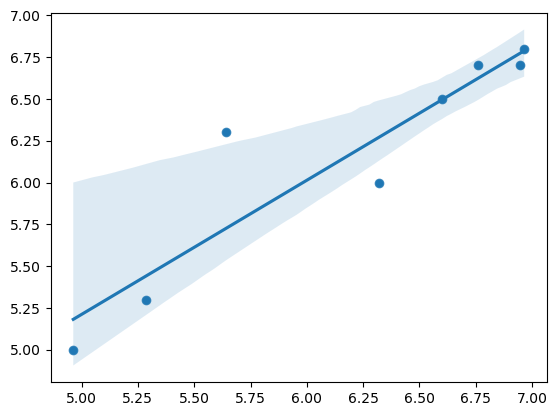

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=np.array(predictions), y=np.array(y_holdout.values))

sns.regplot(x=np.array(predictions), y=np.array(y_holdout.values))

In [35]:
import sagemaker
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: bezdekIris-endpoint
